# Predicting PCE from SMILES strings using gradient boosting

This notebook will test two types of gradient boosting models which can predict the power conversion efficiency (PCE) of organic photovoltaic (OPV) devices, based only on the SMILES string representing their donor molecule. The two gradient boosting approaches we'll compare are:
* LightGBM;
* XGBoost.

In both cases we convert the SMILES string to a ECFP4 ($L = 2048$) molecular fingreprint before feeding them to the model.

## Generate molecular fingerprints and split training-testing sets

csv
xlsx


[19:06:59] SMILES Parse Error: unclosed ring for input: 'CCC(CCCC)Cc1ccc(s1)c1c2cc(sc2c(c2ccc(CC(CC)CCCC)s2)c2cc(C)sc12)c1cc(CC(CC)CCCC)c(s1)c1nnc(s1)c1sc(C)cc2CC(CC)CCCC'
[19:06:59] SMILES Parse Error: unclosed ring for input: 'CCC(CCCC)Cc1ccc(s1)c1c2cc(sc2c(c2ccc(CC(CC)CCCC)s2)c2cc(C)sc12)c1cc(CC(CC)CCCC)c(s1)c1nnc(s1)c1sc(C)cc3CC(CC)CCCC'


Python argument types in
    FingeprintGenerator64.GetCountFingerprintAsNumPy(FingeprintGenerator64, NoneType)
did not match C++ signature:
    GetCountFingerprintAsNumPy(RDKit::FingerprintGenerator<unsigned long long> const* self, RDKit::ROMol mol, boost::python::api::object fromAtoms=[], boost::python::api::object ignoreAtoms=[], int confId=-1, boost::python::api::object customAtomInvariants=[], boost::python::api::object customBondInvariants=[], boost::python::api::object additionalOutput=None)
Skipping this row (k = 120)
Python argument types in
    FingeprintGenerator64.GetCountFingerprintAsNumPy(FingeprintGenerator64, NoneType)
did not match C++ signature:
    GetCountFingerprintAsNumPy(RDKit::FingerprintGenerator<unsigned long long> const* self, RDKit::ROMol mol, boost::python::api::object fromAtoms=[], boost::python::api::object ignoreAtoms=[], int confId=-1, boost::python::api::object customAtomInvariants=[], boost::python::api::object customBondInvariants=[], boost::python::a

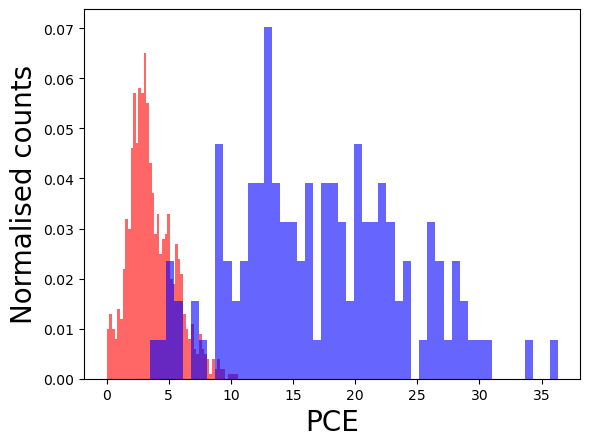

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qcnico.plt_utils import histogram, multiple_histograms
from data_utils import make_dataset_ecfp4, split_dataset

csvpath = '/Users/nico/Desktop/simulation_outputs/OPV_matls/AustinT_harvard_cep/moldata-filtered.csv'
xlsxpath_indoor = '/Users/nico/Desktop/simulation_outputs/OPV_matls/data-indoor.xlsx'

X, y = make_dataset_ecfp4(csvpath,N=1000)
Xtr, ytr, Xte, yte = split_dataset(X,y,train_frac=0.5)

Xindoor, yindoor = make_dataset_ecfp4(xlsxpath_indoor, smiles_col='SMILES(donor)', pce_col='PCE(%)')

fig, ax = plt.subplots()
multiple_histograms([y,yindoor],['HCEP', 'indoor'],bins=50,normalised=True,usetex=False,plt_objs=(fig, ax), show=False, xlabel='PCE')
plt.show()



## Light GBM

Train LightGBM using same params as paper (probs should tune some of the hyperparams; bc the inputs are now different) and see how well it generalises to `data_indoor.xlsx`.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 273
[LightGBM] [Info] Start training from score 3.667713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

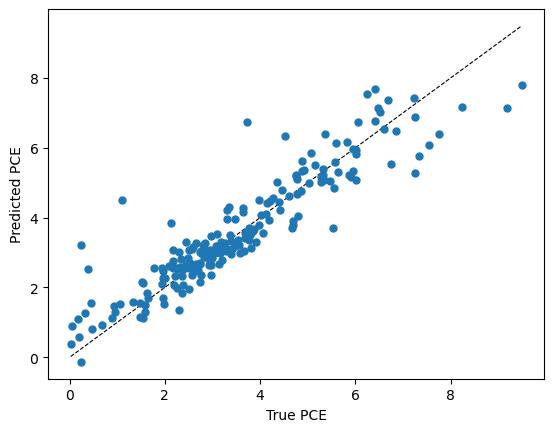

In [2]:
import lightgbm as lgb
from models import test_lgb
from data_utils import plot_predictions

r, yte_pred, model = test_lgb(Xtr, ytr, Xte, yte, model_type='paper', return_preds=True, return_model=True)
print(f'*** Corr. coef for test test r = {r} ***')

plot_predictions(yte, yte_pred, target_name='PCE')

### Test LightGBM model on indoor data

*** Corr coef on indoor data r = -0.14447065248396204 ***


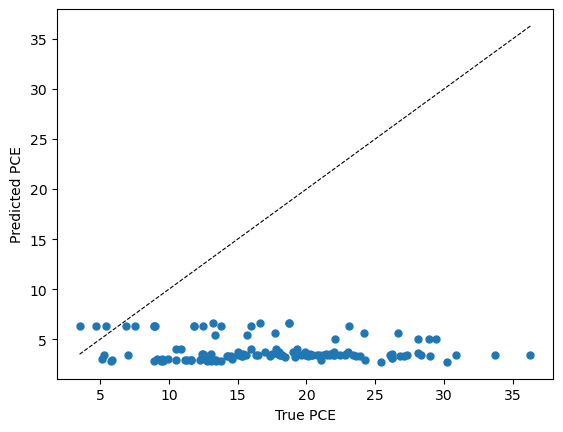

In [6]:
yindoor_pred = model.predict(Xindoor)
rindoor = np.corrcoef(yindoor, yindoor_pred)[0,1]

print(f'*** Corr coef on indoor data r = {rindoor} ***')

plot_predictions(yindoor,yindoor_pred,target_name='PCE')

## XGBoost test